# 1. Import des bibliothèques et modules utiles

In [41]:
import pandas as pd #Pour la manipulation des DataFrames
import numpy as np #Pour les calcul et conversions de type
import re #Module Regex. Pour chercher, nettoyer ou remplacer du texte dans les tweets
from tqdm import tqdm #Pour afficher une barre de progression lors d’une boucle longue
import matplotlib.pyplot as plt #Pour les graphiques
from transformers import pipeline #Bibliothèque de Hugging Face pour le NLP RoBERTa. Permet d'analyser les sentiments dirrects
import torch #Pour la gestion des tenseurs rapidement

# 2. Préparation des données

In [44]:
#Fonction de lecture des fichiers
def load_twitter_csv(path):
    return pd.read_csv(
        path,
        sep=";",             #séparateur
        dtype=str,           #tout en string
        encoding="utf-8",
        low_memory=False,
        quotechar='"',       # protège les textes contenant des ;
        on_bad_lines="skip"  # ignore les lignes corrompues
    )

# Chargement des deux DataFrames
trump = load_twitter_csv("data/trump_nort.csv")
biden = load_twitter_csv("data/biden_nort.csv")


#Identification des colonnes de texte. Certains CSV Kaggle ont plusieurs colonnes texte (tweet, text_clean, tweet_original). Cette fonction cherche automatiquement une colonne dont le nom contient "text"
def find_text_column(df):
    for col in df.columns:
        if "text" in col.lower():
            return col
    raise ValueError("Colonne texte introuvable")

trump_text_col = find_text_column(trump)
biden_text_col = find_text_column(biden)

#Vérification
print("Colonne Trump :", trump_text_col)
print("\n")
print("Colonne Biden :", biden_text_col)
print("\n")


Colonne Trump : text_clean


Colonne Biden : text_clean




# 3. Ajout de la colonne candidat au dataset

In [57]:
#On ajoute une colonne candidate pour identifier facilement à quel candidat appartient chaque tweet.
trump["candidate"] = "Trump"
biden["candidate"] = "Biden"

#Concatenation des deux DataFrames
df = pd.concat([trump, biden], ignore_index=True)
print("Dataset combiné :", df.shape)

#Echantillonnage car l'analyse sur tout le jeu de donnée prend trop de temps
MAX_TWEETS = 10  # par candidat

df_sample = (
    df.groupby("candidate", group_keys=False)
      .apply(lambda x: x.sample(n=min(MAX_TWEETS, len(x)), random_state=42))
)

print("Dataset échantillonné :", df_sample.shape)

trump_sample = df_sample[df_sample['candidate'] == 'Trump']
biden_sample = df_sample[df_sample['candidate'] == 'Biden']


Dataset combiné : (368878, 26)
Dataset échantillonné : (20, 26)


/tmp/ipython-input-3894402397.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(MAX_TWEETS, len(x)), random_state=42))


#  4. Préparation du modèle Hugging Face

In [55]:
#Chargement du modèle avec l'interface simplifiée de HF.
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment", #Modèle pré-entrainé
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", #Transforme le texte en token que le modèle peut comprendre
    device=0  #Pour utiliser le GPU. Changer par -1 si vous vous utiliser le CPU
)

Device set to use cuda:0


# 5. Analyse des sentiments

In [61]:
torch.set_grad_enabled(False) #Désactivation du gradient

def analyze_sentiment(texts, batch_size=64): #Fonction d'analyse de tweets par batch
    results = []
    texts = texts.tolist()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        preds = sentiment_pipeline(batch)
        results.extend(preds)

    return results

print("Analyse des sentiments...")

#Implémentation sur les échantillons
trump_sentiments = analyze_sentiment(trump_sample[trump_text_col]) #Label du tweet et score du tweet entre 0 et 1
biden_sentiments = analyze_sentiment(biden_sample[biden_text_col])

#Ajout des résultats dans le DataFrame
trump_sample.loc[:, "sentiment"] = [s["label"] for s in trump_sentiments]
trump_sample.loc[:, "score"]     = [s["score"] for s in trump_sentiments]

biden_sample.loc[:, "sentiment"] = [s["label"] for s in biden_sentiments]
biden_sample.loc[:, "score"]     = [s["score"] for s in biden_sentiments]


Analyse des sentiments...


100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


# 6. Résumé statistiques

In [63]:
summary_trump = trump_sample.groupby("sentiment").size().reset_index(name="count")
summary_biden = biden_sample.groupby("sentiment").size().reset_index(name="count")

summary_trump["candidate"] = "Trump"
summary_biden["candidate"] = "Biden"

# Combiner les deux
summary = pd.concat([summary_trump, summary_biden], ignore_index=True)
print(summary)


  sentiment  count candidate
0  negative      7     Trump
1   neutral      2     Trump
2  positive      1     Trump
3  negative      5     Biden
4   neutral      3     Biden
5  positive      2     Biden


# 7. Sauvegarde dans un fichier CSV

In [64]:
df_sample.to_csv("tweets_with_sentiment.csv", index=False)
summary.to_csv("sentiment_summary.csv", index=False)

print("\n Analyse terminée et sauvegardée")


✔ Analyse terminée et sauvegardée


# 8. Visualisation

   candidate                                         text_clean sentiment  \
0      Trump  speaking at rally trump mocks fauci dumptrump2...  negative   
1      Trump  blm biden is racist past proof trump is not pa...  negative   
2      Trump              trump parla di kim biden evoca hitler  negative   
3      Trump  that i m under audit crap ain t it bro debatet...  negative   
4      Trump                        trump said what debates2020   neutral   
5      Trump  user user user user georgiavoters disgraceful ...  negative   
6      Trump  long covid may affect multiple parts of body a...  negative   
7      Trump  in his neighborhood trump and his friends were...  negative   
8      Trump  trump i never get any money from russia i get ...   neutral   
9      Trump  user the only thing your father loves about yo...  positive   
10     Biden  ultime news parole chiave coronavirus coronavi...   neutral   
11     Biden  user actually user are an option for irishamer...  negative   

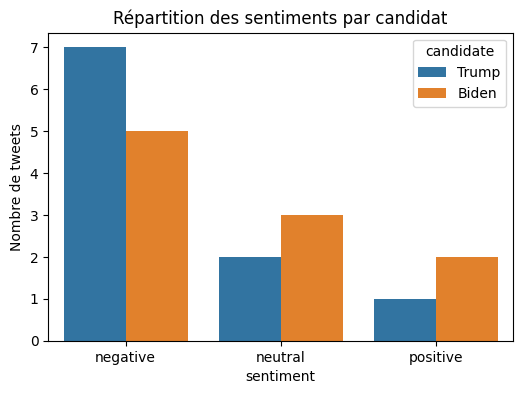

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
# Concaténer les DataFrames analysés
df_result = pd.concat([trump_sample, biden_sample], ignore_index=True)

# Vérifier que tout est correct
print(df_result[["candidate", trump_text_col, "sentiment", "score"]])

plt.figure(figsize=(6,4))
sns.countplot(data=df_result, x="sentiment", hue="candidate")
plt.title("Répartition des sentiments par candidat")
plt.ylabel("Nombre de tweets")
plt.show()


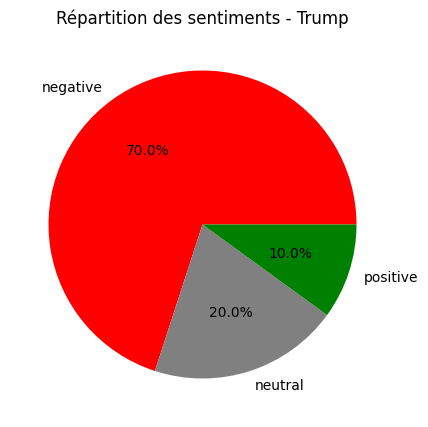

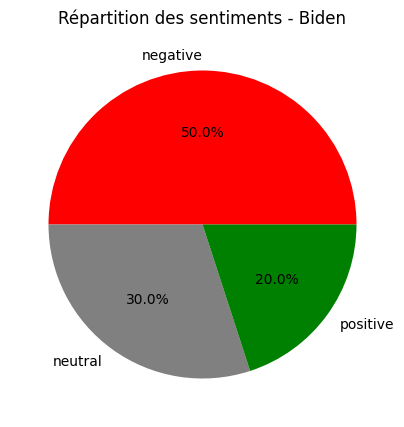

In [71]:
for candidate in ["Trump", "Biden"]:
    data = df_result[df_result["candidate"] == candidate]["sentiment"].value_counts()
    plt.figure(figsize=(5,5))
    plt.pie(data, labels=data.index, autopct="%1.1f%%", colors=["red","grey","green"])
    plt.title(f"Répartition des sentiments - {candidate}")
    plt.show()
